# EstateWise Chapel Hill Real Estate Analysis & Gemini Chat CLI

This notebook covers:

1. Install dependencies  
2. Mount Google Drive & load 2025 data  
3. Clean & wrangle data  
4. Exploratory Data Analysis (EDA)  
5. PCA/t‑SNE + k‑Means clustering  
6. Cluster summaries  
7. Interactive Google Gemini CLI  

In [1]:
# 1. Install Dependencies
!pip install --upgrade pandas numpy scikit-learn matplotlib seaborn google-generativeai python-dotenv

In [2]:
# 2. Imports & Mount Drive
import os, glob, json, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Google Gemini client
import google.generativeai as genai
from dotenv import load_dotenv

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 2.1 Configure Paths & API Key

- Point `path488` to your Zillow JSON folder in Drive  
- Set `GOOGLE_API_KEY` in Colab’s environment (Settings → Secrets)

In [4]:
# Path to folder containing your Zillow JSONs
path488 = '/content/drive/MyDrive/COMP-488/'
zillowfiles = glob.glob(path488 + 'Zillow*.json')
# Keep only 2025 files
zillow25 = [f for f in zillowfiles if '2025' in f]
print("Found 2025 JSON files:", zillow25)

Found 2025 JSON files: ['/content/drive/MyDrive/COMP-488/Zillow-March2025-dataset_part0.json']


## 3. Load & Concatenate 2025 Data

In [5]:
dfs = []
for fp in zillow25:
    with open(fp, 'r', encoding='utf8') as f:
        arr = json.load(f)
    dfs.append(pd.DataFrame(arr))
df_raw = pd.concat(dfs, ignore_index=True)
print(f"Raw 2025 records: {len(df_raw):,}")

Raw 2025 records: 467


## 4. Data Cleaning & Wrangling

- Keep only relevant fields  
- Apply safe parsing and drop invalid entries  

In [6]:
# 4.1 Helpers & field list
def safe_str(val, fallback="Unknown"):
    return val.strip() if isinstance(val, str) and val.strip() else fallback

def safe_num(val, fallback=0, mn=None, mx=None):
    try:
        n = float(val)
    except:
        return fallback
    if mn is not None and n < mn:
        return fallback
    if mx is not None and n > mx:
        return fallback
    return n

keep = [
    "zpid","address","city","state","bedrooms","bathrooms",
    "price","yearBuilt","livingArea","latitude","longitude",
    "homeType","listingDataSource","description"
]

In [8]:
# 4.2 Clean records (fixed yearBuilt NaN handling)
import pandas as pd

current_year = pd.Timestamp.now().year
records = []

for r in df_raw[keep].to_dict('records'):
    zpid = safe_num(r["zpid"], 0)
    addr = r.get("address") or {}
    street = safe_str(addr.get("streetAddress"))
    city = safe_str(r.get("city") or addr.get("city"))
    state = safe_str(r.get("state") or addr.get("state"))
    zipcode = safe_str(addr.get("zipcode"))
    if (
        zpid == 0 or not street
        or city == "Unknown"
        or state == "Unknown"
        or zipcode == "Unknown"
    ):
        continue

    bedrooms = safe_num(r["bedrooms"], 0, 0, 20)
    bathrooms = safe_num(r["bathrooms"], 0, 0, 20)
    price = safe_num(r["price"], 0, 10000, 1e7)

    # handle NaN and out‑of‑bounds yearBuilt
    val_year = safe_num(r["yearBuilt"], 0)
    if pd.isna(val_year) or val_year < 1800 or val_year > current_year + 1:
        yearBuilt = 0
    else:
        yearBuilt = int(val_year)

    livingArea = safe_num(r["livingArea"], 0, 100, 20000)

    records.append({
        "zpid": int(zpid),
        "street": street,
        "city": city,
        "state": state,
        "zipcode": zipcode,
        "bedrooms": bedrooms,
        "bathrooms": bathrooms,
        "price": price,
        "yearBuilt": yearBuilt,
        "livingArea": livingArea,
        "latitude": safe_num(r["latitude"], 0),
        "longitude": safe_num(r["longitude"], 0),
        "homeType": safe_str(r["homeType"]),
        "listingDataSource": safe_str(r["listingDataSource"]),
        "description": safe_str(r["description"]),
    })

df = pd.DataFrame(records)
print(f"Cleaned records: {len(df):,}")
df.head()


Cleaned records: 453


,zpid,street,city,state,zipcode,bedrooms,bathrooms,price,yearBuilt,livingArea,latitude,longitude,homeType,listingDataSource,description
0,50032766,302 Orchard Ln #92,Carrboro,NC,27510,5.0,2.5,764100.0,1991,3013.0,35.897522,-79.077890,SINGLE_FAMILY,Legacy,This 3013 square foot single family home has 5...
1,50037322,232 McCauley St UNIT A,Chapel Hill,NC,27516,8.0,6.0,829100.0,1927,3217.0,35.907510,-79.057396,APARTMENT,Legacy,This 3217 square foot apartment home has 8 bed...
2,251696953,2034 Foxwood Farm Trl,Chapel Hill,NC,27516,4.0,3.5,965600.0,1997,3009.0,35.960842,-79.143480,SINGLE_FAMILY,Legacy,This 3009 square foot single family home has 4...
3,251557517,1509 Partridgeberry Rd #A,Chapel Hill,NC,27516,4.0,2.0,453400.0,1992,1658.0,35.894210,-79.179276,SINGLE_FAMILY,Legacy,This 1658 square foot single family home has 4...
4,50037263,308 Ransom St,Chapel Hill,NC,27516,2.0,1.0,701600.0,1942,1120.0,35.906284,-79.057724,APARTMENT,Legacy,"In-town bungalow, blocks from campus & Frankli..."


## 5. Exploratory Data Analysis (EDA)

In [9]:
# 5.1 Overview
print(df.dtypes, "\n")
print("Missing values:\n", df.isna().sum())

# 5.2 Summary stats
display(df.describe().T)


zpid                   int64
street                object
city                  object
state                 object
zipcode               object
bedrooms             float64
bathrooms            float64
price                float64
yearBuilt              int64
livingArea           float64
latitude             float64
longitude            float64
homeType              object
listingDataSource     object
description           object
dtype: object 

Missing values:
 zpid                  0
street                0
city                  0
state                 0
zipcode               0
bedrooms             45
bathrooms            36
price                 0
yearBuilt             0
livingArea           13
latitude              3
longitude             3
homeType              0
listingDataSource     0
description           0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
zpid,453.0,1.020293e+08,1.235820e+08,4.996870e+07,5.003983e+07,6.007135e+07,9.818678e+07,2.070114e+09
bedrooms,408.0,3.112745e+00,1.252824e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.000000e+01
bathrooms,417.0,2.540767e+00,1.222591e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,8.000000e+00
price,453.0,6.932302e+05,8.416601e+05,0.000000e+00,3.103000e+05,5.150000e+05,8.185000e+05,9.681000e+06
yearBuilt,453.0,1.899680e+03,4.091650e+02,0.000000e+00,1.977000e+03,1.990000e+03,2.000000e+03,2.023000e+03
livingArea,440.0,2.228914e+03,1.824208e+03,0.000000e+00,1.112000e+03,1.646500e+03,2.837750e+03,1.574800e+04
latitude,450.0,3.591968e+01,5.579114e-02,3.505496e+01,3.589934e+01,3.592660e+01,3.594498e+01,3.624017e+01
longitude,450.0,-7.907246e+01,3.166824e-01,-8.371497e+01,-7.906650e+01,-7.904431e+01,-7.901935e+01,-7.835720e+01


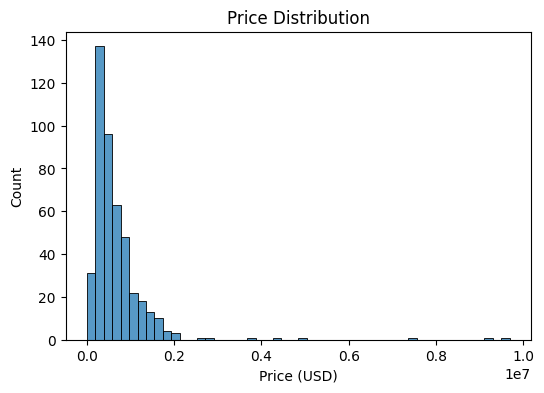

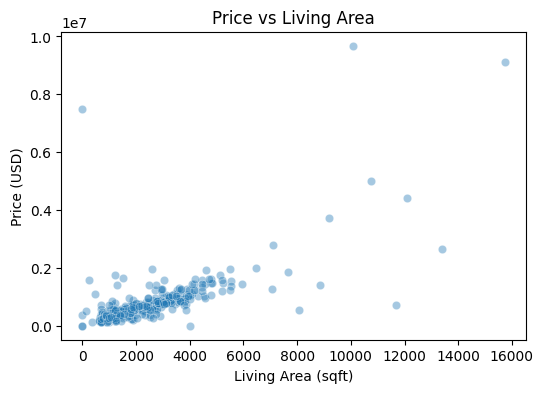

In [10]:
# 5.3 Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=50)
plt.title("Price Distribution")
plt.xlabel("Price (USD)")
plt.show()

# 5.4 Price vs Living Area
plt.figure(figsize=(6,4))
sns.scatterplot(x="livingArea", y="price", data=df, alpha=0.4)
plt.title("Price vs Living Area")
plt.xlabel("Living Area (sqft)")
plt.ylabel("Price (USD)")
plt.show()


## 6. PCA, t-SNE & k‑Means Clustering

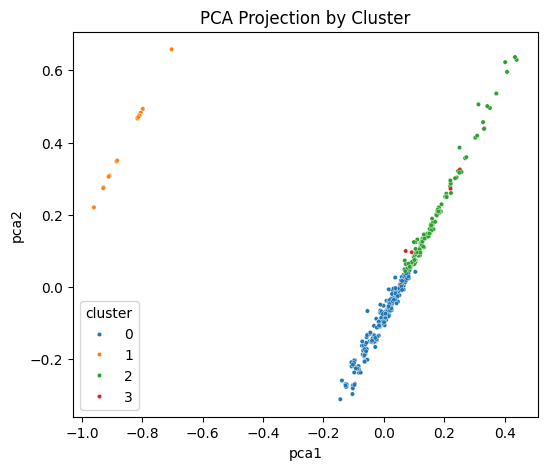

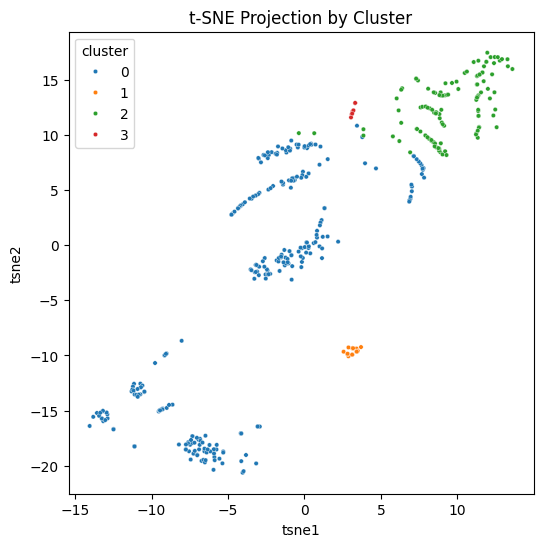

In [12]:
# 6.1 Impute & Normalize features
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

features = ["price", "bedrooms", "bathrooms", "livingArea", "yearBuilt"]

# 1) Impute missing values with column means
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(df[features])

# 2) Scale to [0,1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_imputed)

# 6.2 PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
df["pca1"], df["pca2"] = pca.fit_transform(X).T

# 6.3 t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
df["tsne1"], df["tsne2"] = tsne.fit_transform(X).T

# 6.4 k-Means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X)

# Visualize clusters
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.scatterplot(x="pca1", y="pca2", hue="cluster", data=df, palette="tab10", s=10)
plt.title("PCA Projection by Cluster")
plt.show()

plt.figure(figsize=(6,6))
sns.scatterplot(x="tsne1", y="tsne2", hue="cluster", data=df, palette="tab10", s=10)
plt.title("t-SNE Projection by Cluster")
plt.show()


## 7. Cluster Summaries

In [14]:
cluster_summary = df.groupby("cluster").agg(
    count=("zpid","size"),
    avg_price=("price","mean"),
    avg_sqft=("livingArea","mean"),
    avg_year=("yearBuilt","mean")
).round(2).reset_index()
cluster_summary

,cluster,count,avg_price,avg_sqft,avg_year
0,0,307,491563.84,1497.62,1984.80
1,1,20,375825.00,1434.56,0.00
2,2,119,1010884.87,3615.05,1994.83
3,3,7,5044485.71,11851.86,1976.43


## 8. Interactive Google Gemini CLI

No backend—chat directly with the Gemini API.  
Ensure `GOOGLE_API_KEY` is set in Colab’s Secrets.
For full-fledged and functional web app version, please visit our deployed app at https://estatewise.vercel.app/.

In [21]:
# Install the Google GenAI SDK
!pip install -q -U google-genai python-dotenv

import os
import time
from dotenv import load_dotenv
from google import genai

# 1) Load API key from environment or Colab secrets
load_dotenv()
api_key = userdata.get('GOOGLE_API_KEY')
if not api_key:
    raise RuntimeError("Set GOOGLE_API_KEY in Colab secrets")

# 2) Initialize the GenAI client
client = genai.Client(api_key=api_key)

# 3) Prepare your system prompt (assumes df and cluster_summary already exist in the notebook)
SYSTEM_PROMPT = f"""
You are EstateWise Assistant, an expert real estate concierge for Chapel Hill, NC.
We have clustered {len(df):,} homes into {cluster_summary.shape[0]} clusters:
{cluster_summary.to_dict(orient='records')}

Answer user queries concisely, referencing cluster insights and data trends.
"""

def chat_with_gemini(user_message: str, history: list[str]) -> str:
    """
    Build a single-text prompt from system + history + user, then call generate_content.
    Returns the assistant's reply.
    """
    # 1) Flatten history into lines
    convo = [f"User: {m}" if i % 2 == 0 else f"Assistant: {m}"
             for i, m in enumerate(history)]
    prompt = SYSTEM_PROMPT + "\n" + "\n".join(convo) + f"\nUser: {user_message}\nAssistant:"

    # 2) Call Gemini generate_content
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt,
    )
    return response.text

# 4) CLI loop
print("🏡 Welcome to EstateWise CLI! Type 'exit' to quit.\n")
history: list[str] = []

while True:
    user_input = input("You: ").strip()
    if user_input.lower() in ("exit", "quit"):
        print("EstateWise: Goodbye! 👋")
        break

    try:
        reply = chat_with_gemini(user_input, history)
    except Exception as e:
        print(f"Error during API call: {e}")
        break

    print(f"EstateWise: {reply}\n")
    history.append(user_input)
    history.append(reply)
    time.sleep(0.2)  # small pause to respect rate limits


🏡 Welcome to EstateWise CLI! Type 'exit' to quit.

You: hi
EstateWise: Hello! How can I assist you with your Chapel Hill real estate needs today? I have information on 4 distinct home clusters in the area.


You: tell me about the homes
EstateWise: Okay! Here's a summary of the home clusters I have information on in Chapel Hill:

*   **Cluster 0:** This is the largest cluster with 307 homes. These are generally moderately priced at an average of $491,563.84, with an average square footage of 1497.62, and were typically built around 1984.
*   **Cluster 1:** This is a smaller cluster of 20 homes, averaging $375,825.0 in price and 1434.56 sqft. The year built for this cluster has missing data.
*   **Cluster 2:** This cluster contains 119 homes with a significantly higher average price of $1,010,884.87 and larger square footage, averaging 3615.05 sqft. These homes are a bit newer, typically built around 1994.
*   **Cluster 3:** This is a very exclusive cluster with only 7 homes. These are 